In [40]:
import time
import os
import logging
from pathlib import Path
import datetime
from config import config
from gpt_model import get_completion_from_gpt
from claude import get_completion_from_claude
from format_output import Format_output
import pandas as pd
import matplotlib.pyplot as plt
import csv
import ast 
import seaborn as sns
from math import pi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [3]:
# Set the ROOT_DIR to your repository root.
ROOT_DIR = os.path.dirname(os.path.abspath(''))
# Set the DATA_DIR to the directory where your data resides.
DATA_DIR = os.path.join(ROOT_DIR, 'data/loghub_2k')

In [4]:
save_dir_path = os.path.join(ROOT_DIR, 'results')

now_time = datetime.datetime.now()
date_string = "Semantic_" + now_time.strftime('%Y-%m-%d-%H-%M-%S')
save_dir_separator = "Semantic_" + now_time.strftime('%Y%m%d%H%M%S')

save_dir_now = os.path.join(save_dir_path, save_dir_separator)
raw_save_dir = os.path.join(save_dir_now, "semantic_raw_results/")
Path(raw_save_dir).mkdir(parents=True, exist_ok=True)
semantic_template_file_name = 'semantic_output.txt'
variables_output_file_name = 'variables_output.csv'
semantic_template_output_file_path = raw_save_dir + semantic_template_file_name
variables_output_file_path = raw_save_dir + variables_output_file_name


In [ ]:
# File paths
ground_truth_file_path = os.path.join(DATA_DIR, "ground_truth_template.csv")
raw_log_file_path = os.path.join(DATA_DIR, "combined_raw_logs.txt")

In [6]:
# Load ground truth data
ground_truth_df = pd.read_csv(ground_truth_file_path)
ground_truth_log_templates = ground_truth_df['EventTemplate'].tolist()
ground_truth_variable_templates = ground_truth_df['OID'].tolist()
ground_truth_systems = ground_truth_df['System'].tolist()

In [7]:
# Load raw log messages
with open(raw_log_file_path, 'r') as raw_file:
    raw_logs = [line.strip() for line in raw_file.readlines()]


In [8]:
# Step 1: Reformulate log messages with semantic understanding
counter=0
enhanced_prompts = []
enhanced_prompts_file_path = os.path.join(save_dir_now, "enhanced_prompts.txt")
for raw_log in raw_logs:
    new_prompt=f"""You are provided with a log message. Your task is to understand and extract the meaning behind the semi-structured log message.
                      
                    Log message: {raw_log}. 

                    A log message usually contains a header that is automatically produced by the logging framework, including information such as timestamp, class, and logging level (INFO, DEBUG, WARN etc.).
                    Ignore all these details and just understand meaning behind the natural languagae text which is in the log content.

                    The log content typically consists of many parts: 
                    1. Template - message body, that contains constant strings (or keywords) describing the system events; 
                    2. Parameters/Variables - dynamic variables, which reflect specific runtime status;

                    Please capture the essential context and meaning from the log message to understand the reasoning behind each raw log.
                    Provide only the meaning in 20-25 words from each log message surrounded by <TPL> and </TPL>. 
                    Never provide an explanation of how the meaning is constructed.
                """
    
    enhanced_prompt = get_completion_from_gpt(new_prompt)
    enhanced_prompts.append(enhanced_prompt)
    if counter % 10 == 0:
        print(f'{counter}: {enhanced_prompt}')
    counter+=1    


0: <TPL> Initialization of worker environment successful for workers2 properties file at /etc/httpd/conf/workers2.properties. </TPL>
10: <TPL> High temperature warning on gige5 interface. </TPL>
20: <TPL> Command has been aborted. </TPL>
30: <TPL> CPU has an L2 cache size of 256K. </TPL>
40: <TPL> Connection error while trying to connect to tcpconn4.tencent.com through proxy proxy.cse.cuhk.edu.hk:5070. </TPL>
50: <TPL> autopurge.snapRetainCount set to 3 </TPL>
60: <TPL> RAS KERNEL FATAL disable store gathering </TPL>
70: <TPL> Z coordinate exceeds physical dimension in node map file. </TPL>
80: <TPL> ContainerLauncher received Shuffle port for a specific map task attempt. </TPL>
90: <TPL> Path not allowed in target domain for Safari SearchHelper service due to missing bundle service. </TPL>
100: <TPL> Display woke up notification posted by WindowServer. </TPL>
110: <TPL> insertHiHealthData() bulkSaveDetailHiHealthData fail </TPL>

<TPL> errorCode = 4, errorMessage = ERR_DATA_INSERT </T

In [9]:
print(len(enhanced_prompts))

193


In [10]:
# save and format output data in a csv file
Format_output.save_raw_output(enhanced_prompts_file_path, enhanced_prompts)

# Save all semantic log templates to a file
print(f"Semantic log templates saved to: {enhanced_prompts_file_path}")

Semantic log templates saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241203225023/enhanced_prompts.txt


In [11]:
# convert raw output into formatted file 
Format_output.remove_TPL_from_output(enhanced_prompts_file_path, enhanced_prompts_file_path)

Processed output saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241203225023/enhanced_prompts.txt


In [12]:
# Step 2: Generate log template using zero-shot learning
counter_1 = 0
semantic_based_templates = []
for raw_log, enhanced_prompt in zip(raw_logs, enhanced_prompts):
    semantic_prompt = f"""You will be provided with a log message delimited by <MSG> and </MSG>. 
    You are also provided with the meaning or understanding from the log message as follow: {enhanced_prompt}. 
    
    The log message typically consists of two parts: 
    1. Template - message body, that contains constant strings (or keywords) describing the system events; 
    2. Parameters/Variables - dynamic variables, which reflect specific runtime status.
    You must identify and abstract all the dynamic variables in the log message with suitable placeholders inside angle brackets to extract the corresponding template.
    You must output the template corresponding to the log message. Print only the input log's template surrounded by <TPL> and </TPL>. 
    Never print an explanation of how the template is constructed.
    Here are a few examples of log messages (labeled with Q:) and corresponding templates (labeled with A:):

    Q: <MSG>[081109 204453 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.250.11.85:50010 is added to blk_2377150260128098806 size 67108864]</MSG>
    A: <TPL>[BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:<*> is added to <*> size <*>]</TPL>

    Q: <MSG>- 1129734520 2005.10.19 R17-M0-N0-I:J18-U01 2005-10-19-08.08.40.058960 R17-M0-N0-I:J18-U01 RAS KERNEL INFO shutdown complete</MSG>
    A: <TPL>shutdown complete</TPL>

    Q: <MSG>20231114T101914E ERROR 14 while processing line 123: cannot find input '42'</MSG>
    A: <TPL>ERROR <*> while processing line <*>: cannot find input <*></TPL>

    Q: <MSG>2023-01-14 23:05:14 INFO: Reading data from /user/input/file.txt</MSG>
    A: <TPL>Reading data from <*> </TPL>
    Here is the input log message: <MSG>{raw_log}</MSG>
    Please print the corresponding template.
    """
    response = get_completion_from_gpt(semantic_prompt)
    semantic_based_templates.append(response)
    
    if counter_1 % 10 == 0:
        print(f'{counter_1}: {response}')
        
    counter_1+=1   
   



0: <TPL>workerEnv.init() ok <*> </TPL>
10: <TPL>gige temperature <*> <*> warning</TPL>
20: <TPL>boot_cmd abort <*> <*> Command has been aborted</TPL>
30: <TPL>CPU: L2 cache: <*> </TPL>
40: <TPL>Could not connect through proxy <*> - Proxy closed the connection unexpectedly.</TPL>
50: <TPL>autopurge.snapRetainCount set to <*> </TPL>
60: <TPL>FATAL disable store gathering</TPL>
70: <TPL>ciod: Z coordinate <*> exceeds physical dimension <*> at line <*> of node map file <*> </TPL>
80: <TPL>Shuffle port returned by ContainerManager for attempt_<*>_<*>_<*>_<*> : <*></TPL>
90: <TPL>Path not allowed in target domain for Safari SearchHelper service due to missing bundle service.</TPL>
100: <TPL>CGXDisplayDidWakeNotification [*]: posting kCGSDisplayDidWake</TPL>
110: <TPL>insertHiHealthData() bulkSaveDetailHiHealthData fail errorCode = <*>,errorMessage = <*></TPL>
120: <TPL>Closed due to user request.</TPL>
130: <TPL>Multiple authentication failures for root user from IP address <*>.</TPL>
140: <

In [13]:
# counter_1 = 0
# variable_from_logs = []
# for raw_log, enhanced_prompt in zip(raw_logs, enhanced_prompts):
#     semantic_prompt = f"""You will be provided with a log message delimited by <MSG> and </MSG>. 
#     You are also provided with the meaning or understanding from the log message as follow: {enhanced_prompt}. 
    
#     I want you to categorize the variable(s) in each log message as variable template. 
#     The variable should be classified within the category as below:
#     1. Object ID [OID]	Identification information of an object
#     2. Location Indicator   [LOI]	Location information of an object
#     3. Object Name	[OBN]	Name of an object
#     4.Type Indicator	[TID]	Type information of an object or an action
#     5. Switch Indicator	[SID]	Status of a switch variable
#     6. Time or Duration of an Action	[TDA]	Time or duration of an action
#     7. Computing Resources	[CRS]	Information of computing resource
#     8. Object Amount	[OBA]	Amount of an object
#     9. Status Code	[STC]	Status code of an object or an action
#     10. Other Parameters	[OTP]	Other information does not belong to the above categories]. 
    


#     Static words/parts of the log message are to be annotated with O strictly
#     Organize your variable template within <TPL></TPL> in the following format for each Q: 

#     Q: <MSG>[Jul  1 22:08:16 calvisitor-10-105-163-202 WindowServer[184]: device_generate_desktop_screenshot: authw 0x7fa823c89600(2000), shield 0x7fa8258cac00(2001)]</MSG>
#     A: <TPL>[O O O O O O O O OID OID OID OID OBA]</TPL>

#     Q: <MSG>[nova-scheduler.log.1.2017-05-16_13:53:08 2017-05-16 00:00:57.129 25998 INFO nova.scheduler.host_manager [req-d724a3bd-e314-4f81-a41c-460aa91f24ae - - - - -] Successfully synced instances from host 'cp-1.slowvm1.tcloud-pg0.utah.cloudlab.us']</MSG>
#     A: <TPL>[O O O O O O O O O O O O LOI O LOI OBN O STC O OBA O TDA]</TPL>

#     Above is an example of our log annotation process. Static words are annotated with O, object ID is annotated with OID, 
#     and two location indicators are annotated with LOI.

#     Here is the input log message: <MSG>{raw_log}</MSG>
#     Print only the variable template surrounded by <TPL> and </TPL> and nothing else for each log message. 
#     Never print an explanation of how the variable_template is constructed.
#     """
#     response = get_completion_from_gpt(semantic_prompt)
#     variable_from_logs.append(response)    

#     if counter_1 % 10 == 0:
#         print(f'{counter_1}: {response}')
        
#     counter_1+=1   

In [14]:
counter_1 = 0
variable_count_from_logs = []
for raw_log, enhanced_prompt in zip(raw_logs, enhanced_prompts):
    semantic_prompt = f"""You will be provided with a log message delimited by <MSG> and </MSG>. 
    You are also provided with the meaning or understanding from the log message as follows: {enhanced_prompt}. 
    
    I want you to categorize the variable(s) in each log message as a dictionary with each variable category as the key and the count of occurrences of that category as the value. 
    The variable should be classified within the categories as below:
    1. Object ID [OID]	Identification information of an object
    2. Location Indicator   [LOI]	Location information of an object
    3. Object Name	[OBN]	Name of an object
    4. Type Indicator	[TID]	Type information of an object or an action
    5. Switch Indicator	[SID]	Status of a switch variable
    6. Time or Duration of an Action	[TDA]	Time or duration of an action
    7. Computing Resources	[CRS]	Information of computing resource
    8. Object Amount	[OBA]	Amount of an object
    9. Status Code	[STC]	Status code of an object or an action
    10. Other Parameters	[OTP]	Other information that does not belong to the above categories

    Here is the input log message: <MSG>{raw_log}</MSG>
    
    Please generate a dictionary where each key represents one of the categories listed above and the value represents the count of occurrences of that category in the log message. 
    Only include categories that are present in the log message and do not print anything other than the dictionary. Never print the full name for categories just the code like "OID":2, etc.

    Example of the format:
    {{
        "OID": 2,
        "LOI": 1,
        "STC": 1
    }}
    """
    
    response = get_completion_from_gpt(semantic_prompt)
    variable_count_from_logs.append(response)    

    if counter_1 % 10 == 0:
        print(f'{counter_1}: {response}')
        
    counter_1 += 1


0: {
    "TID": 1,
    "LOI": 1,
    "OBN": 1
}
10: {
    "OID": 2,
    "OBN": 1,
    "TID": 1,
    "CRS": 1,
    "STC": 1,
    "OTP": 1
}
20: {
    "OID": 2,
    "TID": 1,
    "STC": 1
}
30: {
    "CRS": 1,
    "OBN": 1,
    "OTP": 1
}
40: {
    "TID": 1,
    "OBN": 1,
    "LOI": 2,
    "OTP": 1
}
50: {
    "TID": 1,
    "OTP": 1
}
60: {
    "TID": 1,
    "OTP": 1
}
70: {
    "OTP": 1,
    "OBN": 1
}
80: {
    "TID": 1,
    "OBN": 1,
    "OTP": 1
}
90: {
    "TID": 1,
    "OTP": 1
}
100: {
    "OID": 1,
    "OBN": 1,
    "TID": 2,
    "OTP": 1
}
110: {
    "OTP": 1,
    "TID": 1,
    "STC": 1
}
120: {
    "TID": 1,
    "LOI": 1,
    "OTP": 1
}
130: {
    "TID": 1,
    "OTP": 1,
    "STC": 1
}
140: {
    "TID": 1,
    "OTP": 1,
    "OID": 1,
    "TDA": 1
}
150: {
    "OID": 2,
    "LOI": 1,
    "OBN": 1,
    "TID": 1,
    "OTP": 1
}
160: {
    "TID": 1,
    "LOI": 1,
    "OID": 1
}
170: {
    "OID": 1,
    "TDA": 1,
    "OTP": 1
}
180: {
    "OID": 1,
    "LOI": 1,
    "TID": 1,
    "S

In [15]:
# save and format output data in a csv file
Format_output.save_raw_output(semantic_template_output_file_path, semantic_based_templates)
Format_output.save_raw_output(variables_output_file_path, variable_count_from_logs)
# Save all semantic log templates to a file
print(f"Semantic Log templates and Variable templates are saved to: {raw_save_dir}")

Semantic Log templates and Variable templates are saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241203225023/semantic_raw_results/


In [16]:
# convert raw output into formatted file 
Format_output.remove_TPL_from_output(semantic_template_output_file_path, semantic_template_output_file_path)

Processed output saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241203225023/semantic_raw_results/semantic_output.txt


In [17]:
import ast 
fieldnames = ['Index', 'OID', 'LOI', 'OBN', 'TID', 'SID', 'TDA', 'CRS', 'OBA', 'STC', 'OTP']

# Writing the data to the CSV
with open(variables_output_file_path, mode='w', newline='') as variable_file:
    writer = csv.DictWriter(variable_file, fieldnames=fieldnames)
    
    # Write header
    writer.writeheader()
    
    # Write each row of the dictionary results
    for index, log_dict in enumerate(variable_count_from_logs):
        # Convert response (string) to a dictionary if necessary
        if isinstance(log_dict, str):
            log_dict = ast.literal_eval(log_dict)  # Safely convert string to dict

        # Ensure that all keys are present, with missing ones having a value of 0
        row_data = {key: log_dict.get(key, 0) for key in fieldnames[1:]}
        row_data['Index'] = index + 1
        writer.writerow(row_data)

print(f"CSV file '{variables_output_file_path}' created successfully.")

CSV file '/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_20241203225023/semantic_raw_results/variables_output.csv' created successfully.


In [18]:
# File paths
processed_log_template_file_path = semantic_template_output_file_path


In [19]:
# Load processed output data
with open(processed_log_template_file_path, 'r') as processed_file:
    processed_log_templates = [line.strip() for line in processed_file.readlines()]
 

# Ensure the lists are of the same length for comparison
min_length = min(len(ground_truth_log_templates), len(processed_log_templates))
ground_truth_log_templates = ground_truth_log_templates[:min_length]
processed_log_templates = processed_log_templates[:min_length]
ground_truth_systems = ground_truth_systems[:min_length]



In [20]:
# Calculate evaluation metrics for processed_log_templates
accuracy = accuracy_score(ground_truth_log_templates, processed_log_templates)
precision = precision_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
recall = recall_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
f1 = f1_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)

# Print evaluation metrics for processed_log_templates
print(f"Log Template Parsing Accuracy: {accuracy * 100:.2f}%")
print(f"Log Template Precision: {precision * 100:.2f}%")
print(f"Log Template Recall: {recall * 100:.2f}%")
print(f"Log Template F1 Score: {f1 * 100:.2f}%")



Log Template Parsing Accuracy: 36.27%
Log Template Precision: 36.79%
Log Template Recall: 36.27%
Log Template F1 Score: 36.44%


In [21]:
# Calculate correctly parsed log templates for each system
correct_parsed_counts = {}
for system, gt_template, processed_template in zip(ground_truth_systems, ground_truth_log_templates, processed_log_templates):
    if gt_template == processed_template:
        if system not in correct_parsed_counts:
            correct_parsed_counts[system] = 0
        correct_parsed_counts[system] += 1

# Print correctly parsed log templates for each system
print("\nCorrectly Parsed Log Templates per System:")
total=0
for system, count in correct_parsed_counts.items():
    total +=count
    print(f"{system}: {count}")

print(f"Total correctly parsed log templates: {total}")


Correctly Parsed Log Templates per System:
Apache: 5
Linux: 9
Zookeeper: 10
BGL: 5
Hadoop: 4
Mac: 3
HealthApp: 9
OpenSSH: 7
Spark: 12
HDFS: 1
OpenStack: 2
Thunderbird: 3
Total correctly parsed log templates: 70


In [ ]:
# Load ground truth and processed data
ground_truth_df = pd.read_csv(ground_truth_file_path)
processed_df = pd.read_csv(variables_output_file_path)

# Ensure the dataframes are of the same length for comparison
min_length = min(len(ground_truth_df), len(processed_df))
ground_truth_df = ground_truth_df[:min_length]
processed_df = processed_df[:min_length]

# 1. Per Log Message Evaluation (Overall Accuracy per Log)
log_message_accuracies = []
for idx in range(min_length):
    ground_truth_row = ground_truth_df.iloc[idx, 2:]  # Skip 'Index' column
    processed_row = processed_df.iloc[idx, 1:]        # Skip 'Index' column
    accuracy = (ground_truth_row == processed_row).mean()
    log_message_accuracies.append(accuracy)

overall_log_accuracy = sum(log_message_accuracies) / len(log_message_accuracies)
print(f"Overall Log Message Accuracy: {overall_log_accuracy * 100:.2f}%")

# 2. Evaluation Per Variable Type (Precision, Recall, F1 Score, and Accuracy for each variable type)
variable_types = ['OID', 'LOI', 'OBN', 'TID', 'SID', 'TDA', 'CRS', 'OBA', 'STC', 'OTP']
precision_scores = {}
recall_scores = {}
f1_scores = {}
accuracy_scores = {}

for var in variable_types:
    y_true = ground_truth_df[var]
    y_pred = processed_df[var]
    
    precision_scores[var] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_scores[var] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_scores[var] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy_scores[var] = accuracy_score(y_true, y_pred)

# Print Per Variable Type Metrics
print("\nEvaluation Per Variable Type:")
for var in variable_types:
    print(f"{var}:")
    print(f"  Precision: {precision_scores[var] * 100:.2f}%")
    print(f"  Recall: {recall_scores[var] * 100:.2f}%")
    print(f"  F1 Score: {f1_scores[var] * 100:.2f}%")
    print(f"  Accuracy: {accuracy_scores[var] * 100:.2f}%")

# 3. Overall Evaluation for All Variables
ground_truth_flat = ground_truth_df[variable_types].values.flatten()
processed_flat = processed_df[variable_types].values.flatten()

overall_precision = precision_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_recall = recall_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_f1 = f1_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_accuracy = accuracy_score(ground_truth_flat, processed_flat)

# Print Overall Metrics
print("\nOverall Evaluation for All Variables:")
print(f"Overall Precision: {overall_precision * 100:.2f}%")
print(f"Overall Recall: {overall_recall * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1 * 100:.2f}%")

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

Overall Log Message Accuracy: 62.44%

Evaluation Per Variable Type:
OID:
  Precision: 54.82%
  Recall: 48.70%
  F1 Score: 51.18%
  Accuracy: 48.70%
LOI:
  Precision: 46.14%
  Recall: 49.74%
  F1 Score: 47.13%
  Accuracy: 49.74%
OBN:
  Precision: 85.07%
  Recall: 62.18%
  F1 Score: 70.15%
  Accuracy: 62.18%
TID:
  Precision: 97.53%
  Recall: 25.91%
  F1 Score: 40.94%
  Accuracy: 25.91%
SID:
  Precision: 100.00%
  Recall: 91.71%
  F1 Score: 95.68%
  Accuracy: 91.71%
TDA:
  Precision: 76.13%
  Recall: 77.72%
  F1 Score: 76.91%
  Accuracy: 77.72%
CRS:
  Precision: 83.80%
  Recall: 84.46%
  F1 Score: 84.11%
  Accuracy: 84.46%
OBA:
  Precision: 68.00%
  Recall: 75.65%
  F1 Score: 71.62%
  Accuracy: 75.65%
STC:
  Precision: 87.05%
  Recall: 72.54%
  F1 Score: 78.99%
  Accuracy: 72.54%
OTP:
  Precision: 99.48%
  Recall: 35.75%
  F1 Score: 52.60%
  Accuracy: 35.75%

Overall Evaluation for All Variables:
Overall Precision: 76.52%
Overall Recall: 62.44%
Overall F1 Score: 68.19%
Overall Accuracy: 

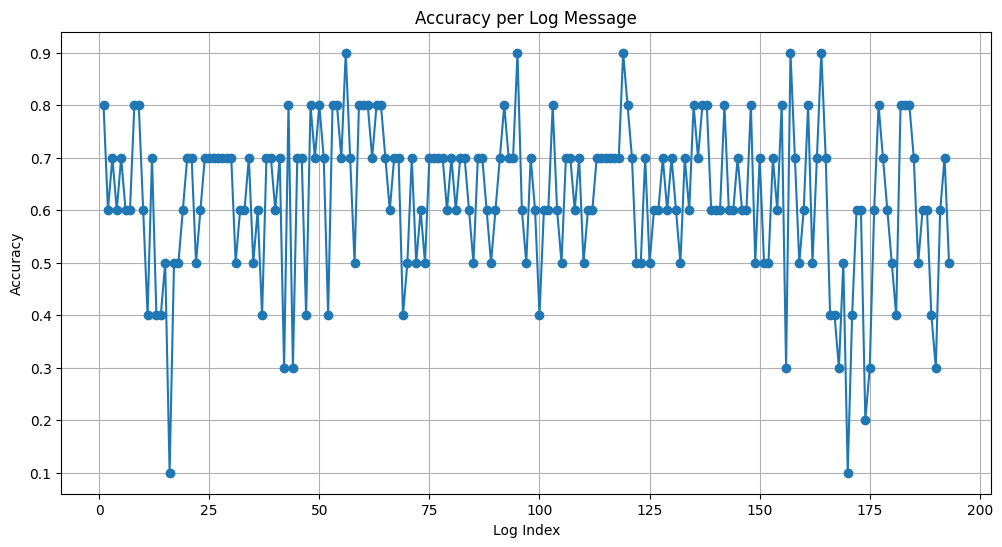

In [ ]:
# 1. Accuracy per Log Message
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(log_message_accuracies) + 1), log_message_accuracies, marker='o')
plt.title('Accuracy per Log Message')
plt.xlabel('Log Index')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

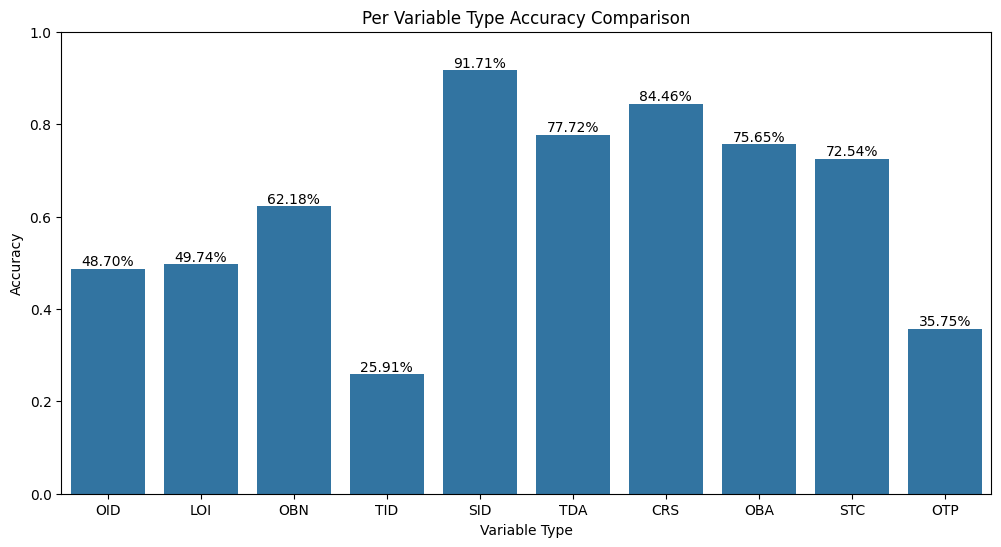

In [43]:
# 2. Per Variable Type Accuracy Comparison with Data Labels
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()))

# Add data labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('Per Variable Type Accuracy Comparison')
plt.xlabel('Variable Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

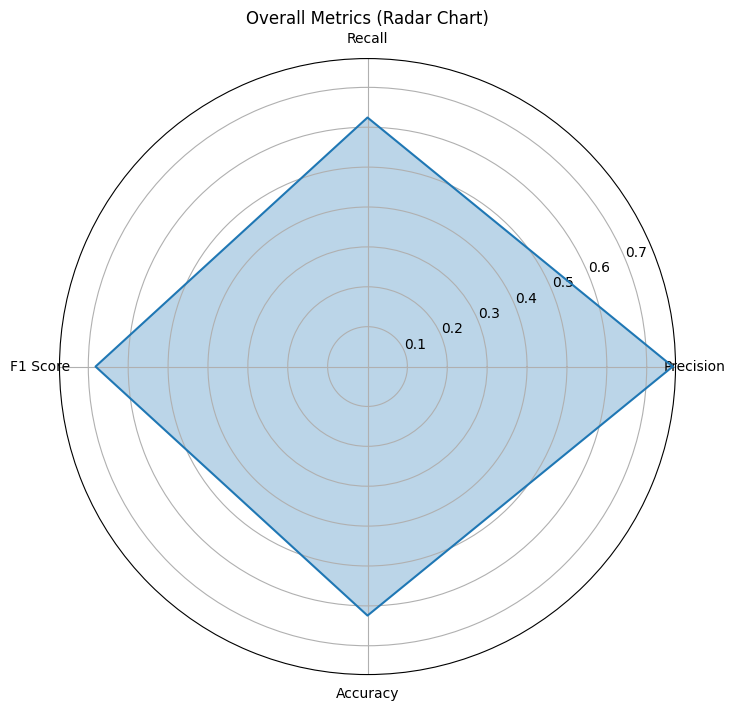

In [ ]:
# 3. Overall Precision, Recall, F1 Score, and Accuracy (Radar Chart)
overall_metrics = {'Precision': overall_precision, 'Recall': overall_recall, 'F1 Score': overall_f1, 'Accuracy': overall_accuracy}  # Replace with actual overall metrics
categories = list(overall_metrics.keys())
values = list(overall_metrics.values())
values += values[:1]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories)
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.3)
plt.title('Overall Metrics (Radar Chart)')
plt.show()

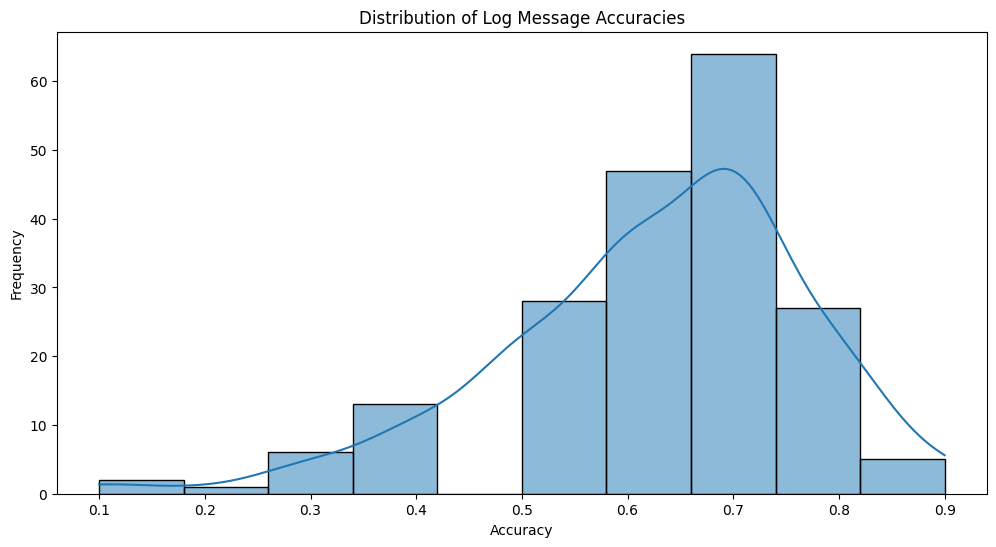

In [ ]:
# 4. Distribution of Log Message Accuracies
plt.figure(figsize=(12, 6))
sns.histplot(log_message_accuracies, bins=10, kde=True)
plt.title('Distribution of Log Message Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

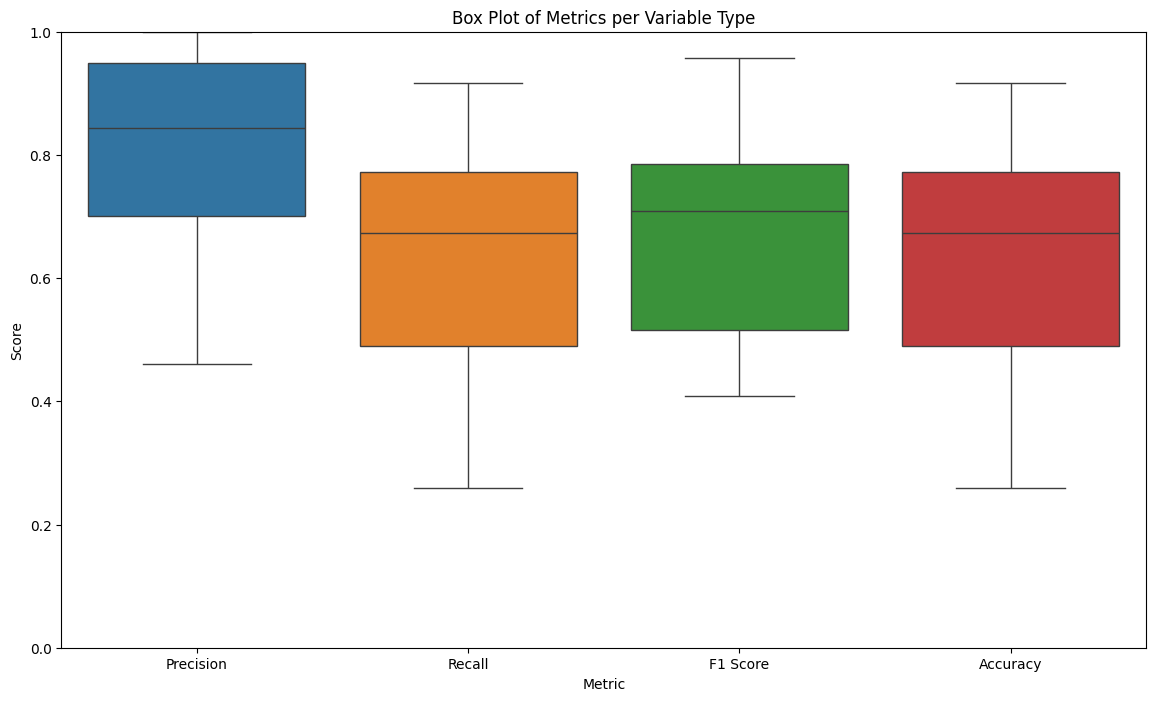

In [ ]:
# 5.Box Plot of Metrics Per Variable Type
plt.figure(figsize=(14, 8))
sns.boxplot(data=metrics_all)
plt.title('Box Plot of Metrics per Variable Type')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()


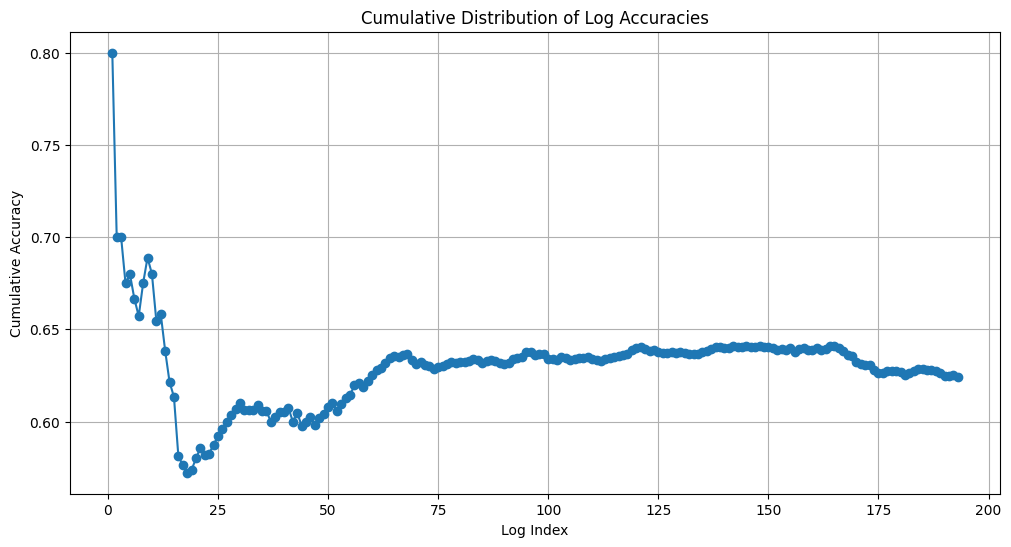

In [ ]:
# 6. Cumulative Distribution of Log Accuracy
cumulative_accuracies = np.cumsum(log_message_accuracies) / np.arange(1, len(log_message_accuracies) + 1)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_accuracies) + 1), cumulative_accuracies, marker='o')
plt.title('Cumulative Distribution of Log Accuracies')
plt.xlabel('Log Index')
plt.ylabel('Cumulative Accuracy')
plt.grid(True)
plt.show()